In [11]:
# Install necessary libraries
!pip install sentence-transformers nltk
!pip install PyPDF2
!pip install transformers
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [12]:
# Import required libraries
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
from google.colab import files

# Download NLTK data for sentence tokenization
nltk.download('punkt_tab')  # This ensures the Punkt tokenizer is available


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
import PyPDF2
from google.colab import files

# Allow the user to upload a PDF file
uploaded = files.upload()

# Read the uploaded PDF file
text = ""
for filename in uploaded.keys():
    with open(filename, 'rb') as file:  # Open the file in binary mode
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()  # Extract text from each page

# Display a snippet of the document
print(f"Uploaded Document Snippet:\n{text[:500]}")


Saving Baker - ASU - Tempe.pdf to Baker - ASU - Tempe.pdf
Saving Care Coach.pdf to Care Coach.pdf
Saving Ceramics Technician Assistant.pdf to Ceramics Technician Assistant.pdf
Uploaded Document Snippet:
Abhiram Sankranthi  
711 west Broadway rd  
Tempe, AZ,85282  
Abhiram.sankranthi8188@gmail.com  
Ph: (480) 875 -4156  
11/10/2024  
 
Hiring Manager  
Aramark  
Dear Hiring Manager,  
I am excited to apply for the Baker position at Aramark. With a strong foundation in 
customer service, time management, and organizational skills, combined with my 
dedication and positive attitude, I am eager to bring my capabilities to your Food 
Services Team. My experience as a Social Media Coordinator and Pla


In [14]:
# Fixed-Size Chunking
def fixed_chunking(text, chunk_size=200):  # Number of words per chunk
    words = text.split()
    return [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]


In [15]:
# Semantic Chunking Function
def semantic_chunking(text, model, threshold=0.6):
    sentences = sent_tokenize(text)
    embeddings = model.encode(sentences, convert_to_tensor=True)

    chunks = []
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]

    for i in range(1, len(sentences)):
        similarity = util.cos_sim(current_embedding, embeddings[i]).item()
        if similarity < threshold:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]
        else:
            current_chunk.append(sentences[i])
            current_embedding = (current_embedding + embeddings[i]) / 2

    if current_chunk:
        chunks.append(' '.join(current_chunk))
    return chunks


In [16]:
# Initialize the SentenceTransformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


In [17]:

# Hybrid Chunking Function
def hybrid_chunking(text, model, fixed_size=200, semantic_threshold=0.6):
    # Start with fixed-size chunks
    fixed_chunks = fixed_chunking(text, chunk_size=fixed_size)

    # Apply semantic chunking to refine fixed chunks
    refined_chunks = []
    for chunk in fixed_chunks:
        sentences = sent_tokenize(chunk)
        embeddings = model.encode(sentences, convert_to_tensor=True)

        current_chunk = [sentences[0]]
        current_embedding = embeddings[0]

        for i in range(1, len(sentences)):
            similarity = util.cos_sim(current_embedding, embeddings[i]).item()
            if similarity < semantic_threshold:
                refined_chunks.append(' '.join(current_chunk))
                current_chunk = [sentences[i]]
                current_embedding = embeddings[i]
            else:
                current_chunk.append(sentences[i])
                current_embedding = (current_embedding + embeddings[i]) / 2

        if current_chunk:
            refined_chunks.append(' '.join(current_chunk))

    return refined_chunks


fixed_chunks = fixed_chunking(text)  # Fixed-size chunking
semantic_chunks = semantic_chunking(text, model)  # Semantic chunking
hybrid_chunks = hybrid_chunking(text, model)  # Hybrid chunking



# Print a sample chunk from each method for comparison
print("\nSample Fixed-Size Chunk:")
print(fixed_chunks[0])

print("\nSample Semantic Chunk:")
print(semantic_chunks[0])

print("\nSample Hybrid Chunk:")
print(hybrid_chunks[0])



Sample Fixed-Size Chunk:
Abhiram Sankranthi 711 west Broadway rd Tempe, AZ,85282 Abhiram.sankranthi8188@gmail.com Ph: (480) 875 -4156 11/10/2024 Hiring Manager Aramark Dear Hiring Manager, I am excited to apply for the Baker position at Aramark. With a strong foundation in customer service, time management, and organizational skills, combined with my dedication and positive attitude, I am eager to bring my capabilities to your Food Services Team. My experience as a Social Media Coordinator and Placement Representative has strengthened my teamwork and adaptability, preparing me well for the fast-paced and collaborative environment at Aramark. In addition to my ability to work effectively under pressure, I am committed to maintaining high standards of safety and sanitation. I believe my background and dedication to delivering excellent service align well with Aramark’s values, and I am eager to contribute to your mission of making a positive impact on employees and customers alike. Than

In [18]:
# Generate chunks using both methods
fixed_chunks = fixed_chunking(text)
semantic_chunks = semantic_chunking(text, model)

# Print chunking results
print(f"Number of Fixed-Size Chunks: {len(fixed_chunks)}")
print(f"Number of Semantic Chunks: {len(semantic_chunks)}")
print(f"Number of Hybrid Chunks: {len(hybrid_chunks)}")


Number of Fixed-Size Chunks: 5
Number of Semantic Chunks: 34
Number of Hybrid Chunks: 38


In [19]:
# Define a query for retrieval
query = "skills"  # Replace with your query
query_embedding = model.encode(query, convert_to_tensor=True)

# Function to retrieve the most relevant chunk
def retrieve_chunk(query_embedding, chunks):
    chunk_embeddings = model.encode(chunks, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, chunk_embeddings)
    best_idx = similarities.argmax().item()  # Find the index of the most relevant chunk
    return chunks[best_idx], similarities[0][best_idx].item()

# Retrieve relevant chunks
fixed_result, fixed_score = retrieve_chunk(query_embedding, fixed_chunks)
semantic_result, semantic_score = retrieve_chunk(query_embedding, semantic_chunks)
hybrid_result, hybrid_score = retrieve_chunk(query_embedding, hybrid_chunks)

# Print the results
print(f"Query: {query}\n")
print(f"Best Fixed-Size Chunk Match:\n{fixed_result}\nScore: {fixed_score:.4f}\n")
print(f"Best Semantic Chunk Match:\n{semantic_result}\nScore: {semantic_score:.4f}\n")
print(f"Best Hybrid Chunk Match:\n{hybrid_result}\nScore: {hybrid_score:.4f}\n")


Query: skills

Best Fixed-Size Chunk Match:
and attention to detail. My background as a Placement Representative and Social Media Coordinator has equipped me with strong organizational, communication, and leadership skills. While these roles may not directly align with kiln operations, they demonstrate my adaptability, problem -solving abilities, and readiness to take on new challenges, includin g learning and mastering specialized technical skills. My key qualifications include: • Strong organizational and time management skills, ensuring efficient workflow. • Ability to adapt to technical environments and learn new skills, such as kiln operation and materials handling. • Physical capability to lift and handle heavy materials, as required by the position. • Effective communication and collaboration skills, essential for working with the ceramics technician and studio monitors. I am particularly drawn to this position’s focus on fostering a safe and efficient learning environment in th

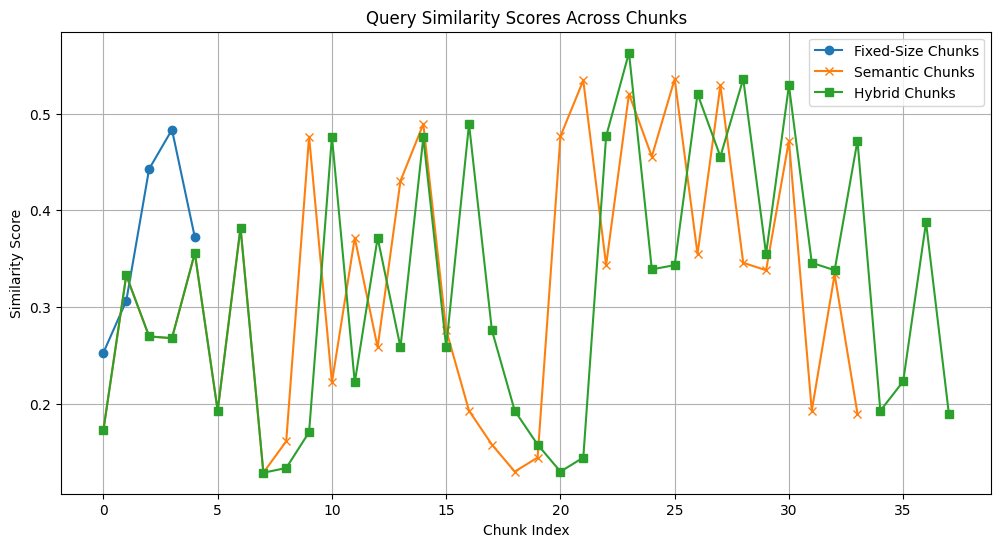

In [20]:
import matplotlib.pyplot as plt

# Compute similarities for visualization
fixed_similarities = util.cos_sim(query_embedding, model.encode(fixed_chunks, convert_to_tensor=True))[0].cpu().numpy()
semantic_similarities = util.cos_sim(query_embedding, model.encode(semantic_chunks, convert_to_tensor=True))[0].cpu().numpy()
hybrid_similarities = util.cos_sim(query_embedding, model.encode(hybrid_chunks, convert_to_tensor=True))[0].cpu().numpy()

# Plot similarities
plt.figure(figsize=(12, 6))
plt.plot(fixed_similarities, label='Fixed-Size Chunks', marker='o')
plt.plot(semantic_similarities, label='Semantic Chunks', marker='x')
plt.plot(hybrid_similarities, label='Hybrid Chunks', marker='s')
plt.title("Query Similarity Scores Across Chunks")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.legend()
plt.grid(True)
plt.show()


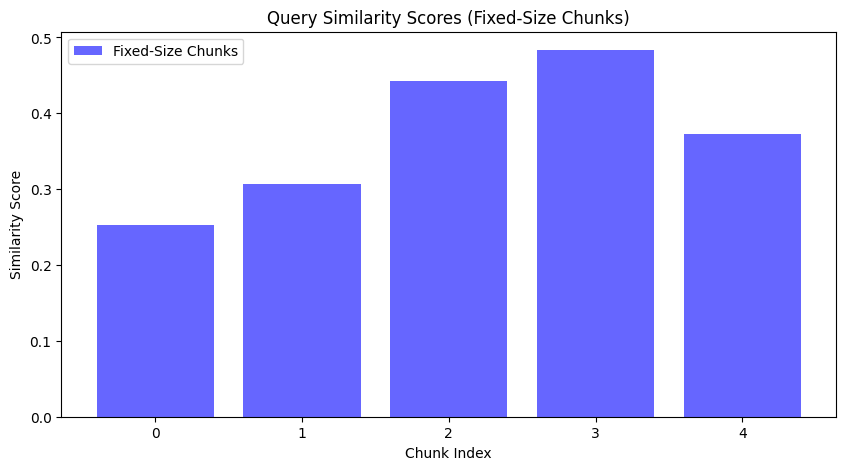

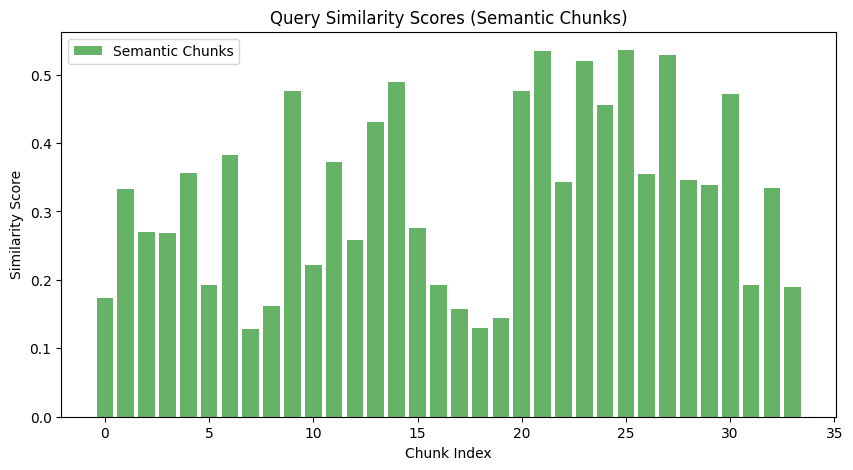

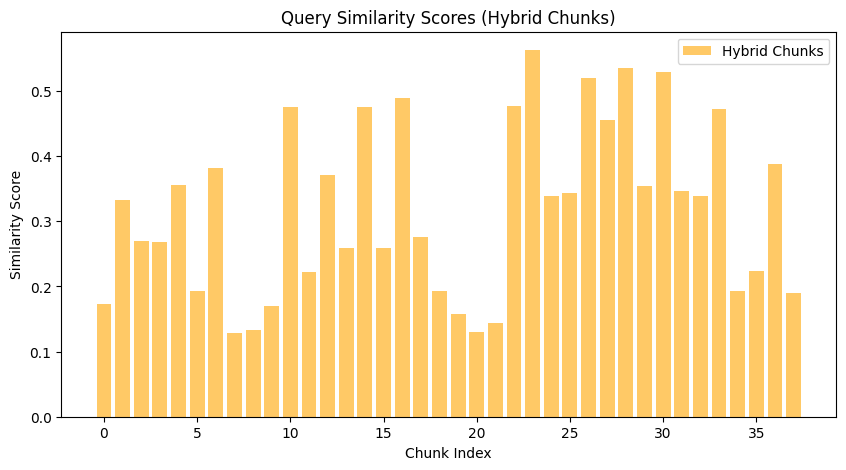

In [21]:
import matplotlib.pyplot as plt

# Compute similarities
fixed_similarities = util.cos_sim(query_embedding, model.encode(fixed_chunks, convert_to_tensor=True))[0].cpu().numpy()
semantic_similarities = util.cos_sim(query_embedding, model.encode(semantic_chunks, convert_to_tensor=True))[0].cpu().numpy()
hybrid_similarities = util.cos_sim(query_embedding, model.encode(hybrid_chunks, convert_to_tensor=True))[0].cpu().numpy()

# Create a bar chart for fixed-size chunks
plt.figure(figsize=(10, 5))
plt.bar(range(len(fixed_similarities)), fixed_similarities, color='blue', alpha=0.6, label='Fixed-Size Chunks')
plt.title("Query Similarity Scores (Fixed-Size Chunks)")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.legend()
plt.show()

# Create a bar chart for semantic chunks
plt.figure(figsize=(10, 5))
plt.bar(range(len(semantic_similarities)), semantic_similarities, color='green', alpha=0.6, label='Semantic Chunks')
plt.title("Query Similarity Scores (Semantic Chunks)")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.legend()
plt.show()

# Create a bar chart for hybrid chunks
plt.figure(figsize=(10, 5))
plt.bar(range(len(hybrid_similarities)), hybrid_similarities, color='orange', alpha=0.6, label='Hybrid Chunks')
plt.title("Query Similarity Scores (Hybrid Chunks)")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.legend()
plt.show()


In [22]:
from transformers import pipeline

# Initialize a text generation pipeline using a pre-trained language model
generator = pipeline("text-generation", model="gpt2")

# Combine the retrieved chunk with the query for context
context_fixed = f"Context: {fixed_result}\nQuery: {query}\nAnswer:"
context_semantic = f"Context: {semantic_result}\nQuery: {query}\nAnswer:"
context_hybrid = f"Context: {hybrid_result}\nQuery: {query}\nAnswer:"

# Generate responses using the context from all three chunking methods
print("Generating response with Fixed-Size Chunk...")
response_fixed = generator(
    context_fixed,
    max_new_tokens=50,  # Generate only 50 tokens
    truncation=True  # Truncate input if it's too long
)
print(response_fixed[0]['generated_text'])

print("\nGenerating response with Semantic Chunk...")
response_semantic = generator(
    context_semantic,
    max_new_tokens=50,  # Generate only 50 tokens
    truncation=True  # Truncate input if it's too long
)
print(response_semantic[0]['generated_text'])

print("\nGenerating response with Hybrid Chunk...")
response_hybrid = generator(
    context_hybrid,
    max_new_tokens=50,  # Generate only 50 tokens
    truncation=True  # Truncate input if it's too long
)
print(response_hybrid[0]['generated_text'])


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating response with Fixed-Size Chunk...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Context: and attention to detail. My background as a Placement Representative and Social Media Coordinator has equipped me with strong organizational, communication, and leadership skills. While these roles may not directly align with kiln operations, they demonstrate my adaptability, problem -solving abilities, and readiness to take on new challenges, includin g learning and mastering specialized technical skills. My key qualifications include: • Strong organizational and time management skills, ensuring efficient workflow. • Ability to adapt to technical environments and learn new skills, such as kiln operation and materials handling. • Physical capability to lift and handle heavy materials, as required by the position. • Effective communication and collaboration skills, essential for working with the ceramics technician and studio monitors. I am particularly drawn to this position’s focus on fostering a safe and efficient learning environment in the ceramics studio. I am committed t

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Context: • Ability to adapt to technical environments and learn new skills, such as kiln operation and materials 
handling.
Query: skills
Answer: • Ability to identify a job problem - to recognize what is on the other side of a problem. • Ability to identify the technical environment for problem solving - to figure out how to solve a problem in a different way

Generating response with Hybrid Chunk...
Context: During my academic and extracurricular experiences, I have cultivated the ability to work in dynamic and technical environments requiring precision
Query: skills
Answer: skills can be learnt within a short amount of time.
Query: skills need to be mastered quickly so that they can be reused or used to meet different needs or needs in different contexts. The skills used in creating a web site will be developed to


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorize chunks for clustering
vectorizer = TfidfVectorizer()

# Vectorize semantic chunks
semantic_chunk_vectors = vectorizer.fit_transform(semantic_chunks)

# Vectorize hybrid chunks
hybrid_chunk_vectors = vectorizer.fit_transform(hybrid_chunks)

# Apply K-Means clustering for semantic chunks
num_clusters = 3  # Adjust as needed
kmeans_semantic = KMeans(n_clusters=num_clusters, random_state=0).fit(semantic_chunk_vectors)

# Apply K-Means clustering for hybrid chunks
kmeans_hybrid = KMeans(n_clusters=num_clusters, random_state=0).fit(hybrid_chunk_vectors)

# Group semantic chunks by clusters
semantic_clustered_chunks = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(kmeans_semantic.labels_):
    semantic_clustered_chunks[label].append(semantic_chunks[idx])

# Group hybrid chunks by clusters
hybrid_clustered_chunks = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(kmeans_hybrid.labels_):
    hybrid_clustered_chunks[label].append(hybrid_chunks[idx])

# Print grouped semantic chunks
print("\nSemantic Chunk Clusters:")
for cluster, chunks in semantic_clustered_chunks.items():
    print(f"\nCluster {cluster}:")
    for chunk in chunks:
        print(chunk[:100], "...")  # Print first 100 characters of each chunk

# Print grouped hybrid chunks
print("\nHybrid Chunk Clusters:")
for cluster, chunks in hybrid_clustered_chunks.items():
    print(f"\nCluster {cluster}:")
    for chunk in chunks:
        print(chunk[:100], "...")  # Print first 100 characters of each chunk



Semantic Chunk Clusters:

Cluster 0:
Abhiram Sankranthi  
711 west Broadway rd  
Tempe, AZ,85282  
Abhiram.sankranthi8188@gmail.com  
Ph: ...
Yours Sincerely,  
Abhiram Sankranthi  Abhiram Sankranthi  
711 west Broadway rd. ...
Yours Sincerely,  
Abhiram Sankranthi . Abhiram Sankranthi  
711 west Broadway rd. ...
Tempe, AZ,85282  
Abhiram.sankranthi8188@gmail.com  
Ph: (480) 875 -4156  
11/27/2024  
 
Community  ...
Sincerely,  
Abhiram Sankranthi ...

Cluster 1:
In addition to my ability to work effectively under pressure, I am committed to 
maintaining high st ...
I look forward to the opportunity to discuss 
how my skills and experiences would be a perfect fit f ...
Tempe, AZ,85282  
Abhiram.sankranthi8188@gmail.com  
Ph: (480) 875 -4156  
11/12/2024  
 
Hiring Com ...
My technical skills in data management and analytics, including proficiency with tools like Python a ...
I am excited about the opportunity to support ASU students in overcoming challenges, embracing their ...
I look

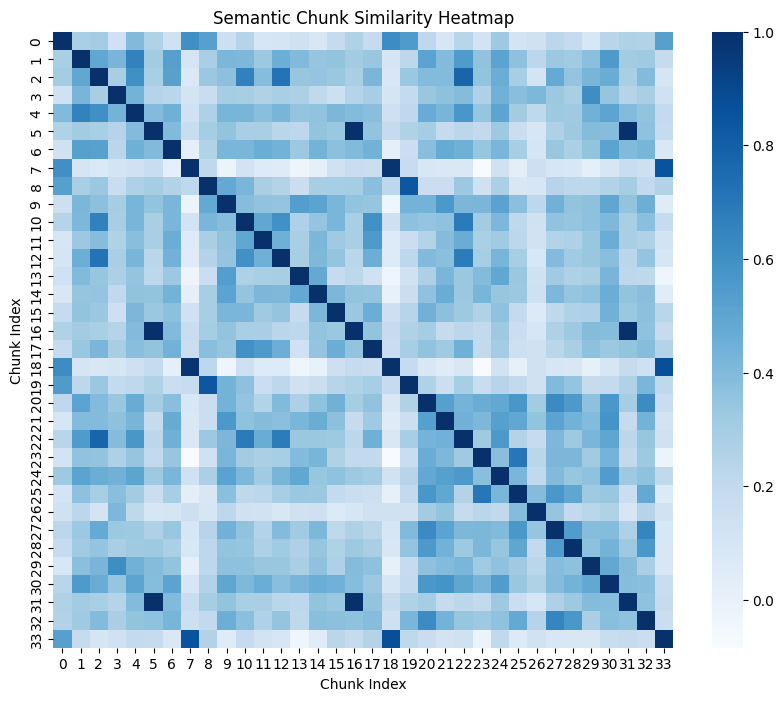

In [24]:
import seaborn as sns

# Compute similarity matrix for semantic chunks
similarity_matrix = util.cos_sim(
    model.encode(semantic_chunks, convert_to_tensor=True),
    model.encode(semantic_chunks, convert_to_tensor=True)
).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap="Blues")
plt.title("Semantic Chunk Similarity Heatmap")
plt.xlabel("Chunk Index")
plt.ylabel("Chunk Index")
plt.show()


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
import traceback
import nltk

nltk.download('punkt')

# Initialize models
print("Initializing models...")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
generator = pipeline("text-generation", model="gpt2")
print("Models initialized successfully.")

# Chunking methods (unchanged from before)
def fixed_chunking(text, chunk_size=200):
    words = text.split()
    return [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

def semantic_chunking(text, model, threshold=0.6):
    from nltk.tokenize import sent_tokenize
    sentences = sent_tokenize(text)
    embeddings = model.encode(sentences, convert_to_tensor=True)

    chunks = []
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]

    for i in range(1, len(sentences)):
        similarity = util.cos_sim(current_embedding, embeddings[i]).item()
        if similarity < threshold:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]
        else:
            current_chunk.append(sentences[i])
            current_embedding = (current_embedding + embeddings[i]) / 2

    if current_chunk:
        chunks.append(' '.join(current_chunk))
    return chunks

def hybrid_chunking(text, model, fixed_size=200, semantic_threshold=0.6):
    fixed_chunks = fixed_chunking(text, chunk_size=fixed_size)
    refined_chunks = []
    for chunk in fixed_chunks:
        refined_chunks.extend(semantic_chunking(chunk, model, threshold=semantic_threshold))
    return refined_chunks

# Chunk retrieval function
def retrieve_chunk(query_embedding, chunks, model):
    chunk_embeddings = model.encode(chunks, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, chunk_embeddings)
    best_idx = similarities.argmax().item()
    return chunks[best_idx], similarities[0][best_idx].item()

# Gradio processing pipeline for multiple files
def gradio_pipeline(files, query):
    try:
        # Step 1: Extract text from uploaded PDFs
        print("\nStep 1: Extracting text from the uploaded PDFs...")
        all_text = ""
        for file in files:
            try:
                reader = PdfReader(file.name)
                for page in reader.pages:
                    all_text += page.extract_text()
            except Exception as e:
                print(f"Error reading {file.name}: {str(e)}")
                continue

        if not all_text.strip():
            print("Error: None of the uploaded documents contain extractable text.")
            return "Error: None of the uploaded documents contain extractable text.", "", ""

        print(f"Extracted text snippet:\n{all_text[:500]}")

        # Step 2: Generate chunks
        print("\nStep 2: Generating chunks...")
        try:
            fixed_chunks = fixed_chunking(all_text)  # Fixed-size chunking
            semantic_chunks = semantic_chunking(all_text, model)  # Semantic chunking
            hybrid_chunks = hybrid_chunking(all_text, model)  # Hybrid chunking
            print(f"Generated {len(fixed_chunks)} fixed-size chunks.")
            print(f"Generated {len(semantic_chunks)} semantic chunks.")
            print(f"Generated {len(hybrid_chunks)} hybrid chunks.")
        except Exception as e:
            error_message = f"Error in chunking: {str(e)}"
            print(error_message)
            return error_message, "", ""

        # Step 3: Process query and retrieve results
        print("\nStep 3: Processing query and retrieving results...")
        try:
            query_embedding = model.encode(query, convert_to_tensor=True)
            fixed_result, fixed_score = retrieve_chunk(query_embedding, fixed_chunks, model)
            semantic_result, semantic_score = retrieve_chunk(query_embedding, semantic_chunks, model)
            hybrid_result, hybrid_score = retrieve_chunk(query_embedding, hybrid_chunks, model)
            print(f"Query processed successfully. Results retrieved.")
        except Exception as e:
            error_message = f"Error in query processing: {str(e)}"
            print(error_message)
            return error_message, "", ""

        # Step 4: Generate responses
        print("\nStep 4: Generating responses...")
        try:
            response_fixed = generator(f"Context: {fixed_result}\nQuery: {query}\nAnswer:", max_new_tokens=50, truncation=True)
            response_semantic = generator(f"Context: {semantic_result}\nQuery: {query}\nAnswer:", max_new_tokens=50, truncation=True)
            response_hybrid = generator(f"Context: {hybrid_result}\nQuery: {query}\nAnswer:", max_new_tokens=50, truncation=True)
            print("Responses generated successfully.")
        except Exception as e:
            error_message = f"Error in response generation: {str(e)}"
            print(error_message)
            return error_message, "", ""

        # Step 5: Return results
        print("\nStep 5: Returning results...")
        return (
            response_fixed[0]['generated_text'],
            response_semantic[0]['generated_text'],
            response_hybrid[0]['generated_text']
        )
    except Exception as e:
        error_message = traceback.format_exc()
        print(f"Unexpected error: {error_message}")
        return f"Error encountered: {error_message}", "", ""

# Gradio Interface Setup for Multiple Files
print("Setting up Gradio interface...")
interface = gr.Interface(
    fn=gradio_pipeline,
    inputs=[
        gr.File(file_types=[".pdf"], file_count="multiple", label="Upload PDF Documents"),
        gr.Textbox(lines=1, placeholder="Enter your query here", label="Query")
    ],
    outputs=[
        gr.Textbox(label="Fixed-Size Chunk Response"),
        gr.Textbox(label="Semantic Chunk Response"),
        gr.Textbox(label="Hybrid Chunk Response")
    ],
    title="Document Processing Pipeline for Multiple PDFs",
    description="Upload multiple PDF documents and enter a query. The pipeline processes the documents and retrieves responses using Fixed-Size, Semantic, and Hybrid Chunking."
)

# Launch the Gradio app
interface.launch(debug=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initializing models...
Models initialized successfully.
Setting up Gradio interface...
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://21f8659660cea2bb8c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



Step 1: Extracting text from the uploaded PDFs...
Extracted text snippet:
Abhiram Sankranthi  
711 west Broadway rd  
Tempe, AZ,85282  
Abhiram.sankranthi8188@gmail.com  
Ph: (480) 875 -4156  
09/11/2024  
 
Hiring Committee  
The Sanford School, Child Development Laboratory  
Arizona State University  
Tempe, AZ  
Dear Hiring Manager, 
I am excited to apply for the Classroom Assistant I position at ASU’s Child Development 
Laboratory. As a graduate student at Arizona State University, I am available on -campus and 
eager to contribute to a nurturing and engaging envi

Step 2: Generating chunks...
Generated 6 fixed-size chunks.
Generated 47 semantic chunks.
Generated 52 hybrid chunks.

Step 3: Processing query and retrieving results...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Query processed successfully. Results retrieved.

Step 4: Generating responses...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Responses generated successfully.

Step 5: Returning results...
